In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm
!pip install torchsampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image

import os
import csv

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision as TV
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from torchsampler import ImbalancedDatasetSampler

import timm

import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# data_dir_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/CLASSIFICATION_dataset/'

data_dir_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/TRASH-NET/dataset-original/'

# Statistics' dataset

Text(0, 0.5, 'Number of images')

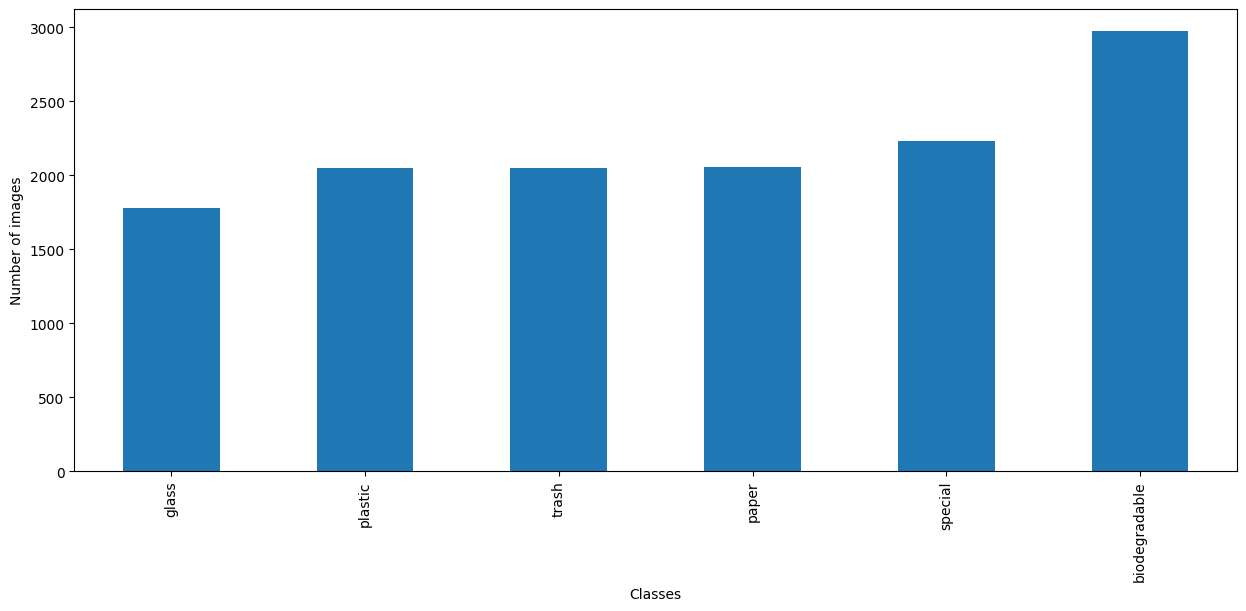

In [ ]:
# number of images in each class for training datasets
data_dic = {}
dict_label = {0: 'biodegradable', 1 : 'glass', 2 : 'paper', 3 : 'plastic', 4 : 'special', 5 : 'trash'}
# Specify the file name
csv_file_name = ['train_class_balanced.csv', 'val_class_balanced.csv', 'test_class_balanced.csv']

# read from CVS Mix-Waste-Pictures

for file in csv_file_name:
  with open(data_dir_path+file, 'r', newline='') as csvfile:
      csv_reader = csv.reader(csvfile)
      for row in csv_reader:
        if dict_label[int(row[1])] not in data_dic:
          data_dic[dict_label[int(row[1])]] = 1
        data_dic[dict_label[int(row[1])]] += 1

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Classes')
plt.ylabel('Number of images')

# read from CVS Taco for classification

# dict_label = {0: 'trash', 1 : 'glass', 2 : 'paper', 3 : 'plastic'}

# with open('/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO/taco_for_classification.csv', 'r', newline='') as csvfile:
#   csv_reader = csv.reader(csvfile)
#   for row in csv_reader:
#     if dict_label[int(row[4])] not in data_dic:
#       data_dic[dict_label[int(row[4])]] = 1
#     data_dic[dict_label[int(row[4])]] += 1

# data_df= pd.Series(data_dic)
# plt.figure(figsize = (15, 6))
# data_df.sort_values().plot(kind = 'bar')
# plt.xlabel('Classes')
# plt.ylabel('Number of images')

# DATASET

In [ ]:
# TO USE WITH NOT FIX PARTION OF TRAINING, VALIDATION AND TEST SETS AND TO COLLECT THE DATA DIRECTLY FROM THE DIRECTORY

class CustomImageFolder(ImageFolder):
  def __init__(self, root, transform=None, target_transform=None):
    # Use init of superclass CustomImageFolder
    super(CustomImageFolder, self).__init__(root, transform, target_transform)

  def __getitem__(self, index):
    path, target = self.samples[index]

    # Print the image path and label during loading
    # print(f"Image path: {path}, Label: {target}")

    # Load image
    img = super(CustomImageFolder, self).__getitem__(index)

    return img

In [ ]:
# TO USE WITH TRAINING, VALIDATION AND TEST SETS CSV FILE

class ClassificationDataset(Dataset):
  def __init__(self, csv_file, transform=None):
    self.data_frame = pd.read_csv(csv_file)
    self.transform = transform
    self.root_dir = '/content/drive/MyDrive/VISIOPE_Project/DATASET/CLASSIFICATION_dataset/'

  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, idx):
    img_path = self.data_frame.iloc[idx, 0]
    label = int(self.data_frame.iloc[idx, 1])

    # Load image
    image = Image.open(self.root_dir+img_path).convert("RGB")

    # Apply transformations
    if self.transform:
        image = self.transform(image)

    return image, label

In [ ]:
# TO USE WITH TRAINING, VALIDATION AND TEST SETS CSV FILE FOR CROPPED DATASET

# add other parameter to distinguish taco class with 4 or 6 labels

class ClassificationCropDataset(Dataset):
  def __init__(self, root, csv_file, taco,TACO4, transform=None):
    self.root_dir_csv = root #'/content/drive/MyDrive/VISIOPE_Project/DATASET/CLASSIFICATION_dataset/crop_dataset/'#TACO/'
    self.data_frame = pd.read_csv(self.root_dir_csv+csv_file)
    self.transform = transform
    self.root_dir_image = root #'/content/drive/MyDrive/VISIOPE_Project/DATASET/CLASSIFICATION_dataset/crop_dataset/'#TACO/'
    self.labels = []
    self.taco = taco
    self.taco4 = TACO4

    rows_to_remove = []

    # When we worked with TACO, we decided to narrow down the number of classes to 4. (with out special and biodegradable)
    # This way, we ensure that the DataLoader doesn't load extra images.
    if taco4:
      for idx in range(len(self.data_frame)):
        if self.data_frame.iloc[idx, 4] == 0 or self.data_frame.iloc[idx, 4] == 4:
          #print(self.data_frame.iloc[idx])
          rows_to_remove.append(idx)

    # To remove the selected rows
    self.data_frame = self.data_frame.drop(index=rows_to_remove)

  def __len__(self):
    return len(self.data_frame)

  def __getframe__(self):
    return self.data_frame

  def get_labels(self):
    pos_label = 1
    if self.taco: pos_label = 4
    for idx in range(len(self.data_frame)):

      label = int(self.data_frame.iloc[idx, pos_label])  # for TACO the column of label is 4
      if self.taco4:
        if label == 5: label = 0
      self.labels.append(label)
    return self.labels


  def __getitem__(self, idx):
    pos_label = 1
    if self.taco: pos_label = 4

    img_path = self.data_frame.iloc[idx, 0]
    if self.taco:
      bbox = self.data_frame.iloc[idx, 2]
      bbox = bbox[1:-1].split(', ')
      print(bbox, type(bbox))
      left, top, right, bottom = bbox
    label = int(self.data_frame.iloc[idx, pos_label])   # for TACO the column of label is 4
    if self.taco4:
      if label == 5: label = 0
    #print(label, type(label))

    # Load image
    image = Image.open(self.root_dir_image+img_path).convert("RGB")
    # Crop Image with bbox dataset
    if self.taco: image = image.crop((float(bbox[0]), float(bbox[1]), float(bbox[0])+float(bbox[2]), float(bbox[1])+float(bbox[3])))

    # Apply transformations
    if self.transform:
        image = self.transform(image)

    return image, label

In [ ]:
#### TO INITIALIZE DATASET AND DATALOADER WITH DIFFERENT TYPE OF CLASSES AND DATASETS ###
# VARIABLE TO MANAGE THE CONDITION
BALANCED = False
CROP = False
CSV = False
DO_OVERSAMPLING = False
TACO = False
TACO4 = False

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


if TACO or CROP:
  if TACO:
    root =  '/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO/'
    path_set = 'taco_for_classification.csv'
    path_train = 'taco_for_classification_train.csv'
    path_val = 'taco_for_classification_val.csv'
    path_test = 'taco_for_classification_test.csv'
  else:
    root =  '/content/drive/MyDrive/VISIOPE_Project/DATASET/CLASSIFICATION_dataset/crop_dataset/'
    path_train = 'crop_train_class.csv'
    path_val = 'crop_val_class.csv'
    path_test = 'crop_test_class.csv'

  if CSV:
    train_dataset = ClassificationCropDataset(root, path_train, TACO, TACO4, transform)
    val_dataset = ClassificationCropDataset(root, path_val, TACO, TACO4, transform)
    test_dataset = ClassificationCropDataset(root, path_test, TACO, TACO4, transform)

  else:
    if TACO: custom_dataset = ClassificationCropDataset(root, path_set, TACO, TACO4, transform=transform)
    if CROP: custom_dataset = CustomImageFolder(root=data_dir_path+'crop_dataset/', transform=transform)
    train_size = int(0.7 * len(custom_dataset))
    val_size = int(0.15 * len(custom_dataset))
    test_size = len(custom_dataset) - train_size - val_size

    # Partiotion of dataset
    train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

  if DO_OVERSAMPLING:
    train_loader = DataLoader(train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), batch_size=128, shuffle=False)
    val_loader = DataLoader(val_dataset, sampler=ImbalancedDatasetSampler(val_dataset), batch_size = 128, shuffle=False)
    test_loader = DataLoader(test_dataset, sampler=ImbalancedDatasetSampler(test_dataset), batch_size = 128, shuffle=False)
  else:
    train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = 128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size = 128, shuffle=False)

else: # MIX-WASTE-PICTURES
  if CSV:
    if BALANCED:
      train_dataset = ClassificationDataset(data_dir_path+'train_class_balanced.csv', transform)
      val_dataset = ClassificationDataset(data_dir_path+'val_class_balanced.csv', transform)
      test_dataset = ClassificationDataset(data_dir_path+'test_class_balanced.csv', transform)
    else:
      train_dataset = ClassificationDataset(data_dir_path+'train_class.csv', transform)
      val_dataset = ClassificationDataset(data_dir_path+'val_class.csv', transform)
      test_dataset = ClassificationDataset(data_dir_path+'test_class.csv', transform)
  else:
    custom_dataset = CustomImageFolder(root=data_dir_path, transform=transform)

    train_size = int(0.7 * len(custom_dataset))
    val_size = int(0.15 * len(custom_dataset))
    test_size = len(custom_dataset) - train_size - val_size

    # Partiotion of dataset
    train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])


  train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size = 128, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size = 128, shuffle=False)


In [ ]:
# batchs' number
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

15
3
4


# MODEL

In [ ]:
# CUSTOM CLASSIFIER CLASS
class CustomClassifierModel(nn.Module):

  def __init__(self, num_classes, model_type):
    super(CustomClassifierModel, self).__init__()
    self.model_type = model_type

    if self.model_type == 'eff':
      self.model = timm.create_model("efficientnet_b0", pretrained=True)
      in_features = self.model.classifier.in_features
      self.model.classifier = nn.Linear(in_features, num_classes)

    if self.model_type == 'resnet18':
      self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
      in_features = self.resnet.fc.in_features
      self.resnet.fc = nn.Linear(in_features, num_classes)

    if self.model_type == 'resnet50':
      self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
      in_features = self.resnet.fc.in_features
      self.resnet.fc = nn.Linear(in_features, num_classes)

    if self.model_type == 'vgg16':
      self.model = models.vgg16(weights=models.VGG16_Weights.DEFAULT, progress = True)
      self.model.classifier[6] = nn.Linear(4096, num_classes)


  def forward(self, x):
    if self.model_type == 'resnet18': return self.resnet(x)
    if self.model_type == 'resnet50': return self.resnet(x)
    if self.model_type == 'eff': return self.model(x)
    if self.model_type == 'vgg16': return self.model(x)

In [ ]:
# Instantiate the model
num_classes = 6
model_type = 'resnet50'
# 'resnet18'
# 'resnet50'
# 'vgg16'
# 'efficientNet'

model = CustomClassifierModel(num_classes, model_type)
model.to(device)

criterion = nn.CrossEntropyLoss()
#criterion = TV.ops.sigmoid_focal_loss() #FocalLoss(input, target)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001) # to try with effnet

#scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = 0.001, end_factor = 0.3, total_iters = min(1000, len(train_loader)-1))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer) #default parameters

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 51.5MB/s]


## Training

In [ ]:
num_epochs = 10
c = 0
k = 0

train_loss = []
val_loss = []
accuracy = []
accuracy_v = []

for epoch in range(num_epochs):

  #METRICS FOR EACH BATCH
  running_loss_train = 0.0
  correct_predictions_train = 0
  total_samples_train = 0

  running_loss_val = 0.0
  correct_predictions_val = 0
  total_samples_val = 0

  true_label_train = []
  true_label_val = []

  pred_label_train = []
  pred_label_val = []

  print('TRAIN')

  for images, labels in train_loader:
    c += 1
    #if  c%10 == 0: print(c)
    x = images.to(device)
    y = labels.to(device)
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # Update statistics
    running_loss_train += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total_samples_train += labels.size(0)
    correct_predictions_train += (predicted == y).sum().item()

    y = y.cpu()
    predicted = predicted.cpu()

    for elem in y: true_label_train.append(elem)
    for elem in predicted: pred_label_train.append(elem)

  # scheduler.step(running_loss_train)      #it can be in or out the batch loop/epochs... try with updates for each epoch

  # Calculate accuracy and average loss for the epoch
  accuracy_train = correct_predictions_train / total_samples_train
  average_loss_train = running_loss_train / len(train_loader)

  print('VAL')

  model.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      k += 1
      #if  k%5 == 0: print(k)
      x = images.to(device)
      y = labels.to(device)
      outputs = model(x)
      loss = criterion(outputs, y)

      # Update statistics
      running_loss_val += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total_samples_val += labels.size(0)
      correct_predictions_val += (predicted == y).sum().item()

      y = y.cpu()
      predicted = predicted.cpu()

      for elem in y: true_label_val.append(elem)
      for elem in predicted: pred_label_val.append(elem)

    scheduler.step(running_loss_val)      #it can be in or out the batch loop/epochs... try with updates for each epoch

    # Calculate accuracy and average loss for the epoch
    accuracy_val = correct_predictions_val / total_samples_val
    average_loss_val = running_loss_val / len(val_loader)

    train_loss.append(average_loss_train)
    val_loss.append(average_loss_val)
    accuracy.append(accuracy_train)
    accuracy_v.append(accuracy_val)

    print(f"Epoch {epoch + 1}, Loss train: {average_loss_train:.4f}, Accuracy train: {accuracy_train * 100:.2f}%, Loss val: {average_loss_val:.4f}, Accuracy val: {accuracy_val * 100:.2f}%")

print("TRAINING REPORT")
print(classification_report(true_label_train, pred_label_train, digits = 4))

print("VALIDATION REPORT")
print(classification_report(true_label_val, pred_label_val, digits = 4))

TRAIN
VAL
Epoch 1, Loss train: 1.7517, Accuracy train: 23.42%, Loss val: 1.6835, Accuracy val: 41.67%
TRAIN
VAL
Epoch 2, Loss train: 1.5848, Accuracy train: 48.52%, Loss val: 1.4225, Accuracy val: 59.64%
TRAIN
VAL
Epoch 3, Loss train: 1.2772, Accuracy train: 61.74%, Loss val: 1.0414, Accuracy val: 72.92%
TRAIN
VAL
Epoch 4, Loss train: 0.8154, Accuracy train: 75.68%, Loss val: 0.6808, Accuracy val: 76.82%
TRAIN
VAL
Epoch 5, Loss train: 0.5142, Accuracy train: 83.60%, Loss val: 0.6198, Accuracy val: 78.12%
TRAIN
VAL
Epoch 6, Loss train: 0.4888, Accuracy train: 81.48%, Loss val: 0.4391, Accuracy val: 85.94%
TRAIN
VAL
Epoch 7, Loss train: 0.3153, Accuracy train: 88.23%, Loss val: 0.3451, Accuracy val: 86.72%
TRAIN
VAL
Epoch 8, Loss train: 0.2167, Accuracy train: 92.69%, Loss val: 0.3044, Accuracy val: 88.28%
TRAIN
VAL
Epoch 9, Loss train: 0.1536, Accuracy train: 95.09%, Loss val: 0.2916, Accuracy val: 89.58%
TRAIN
VAL
Epoch 10, Loss train: 0.1350, Accuracy train: 95.09%, Loss val: 0.3300, 

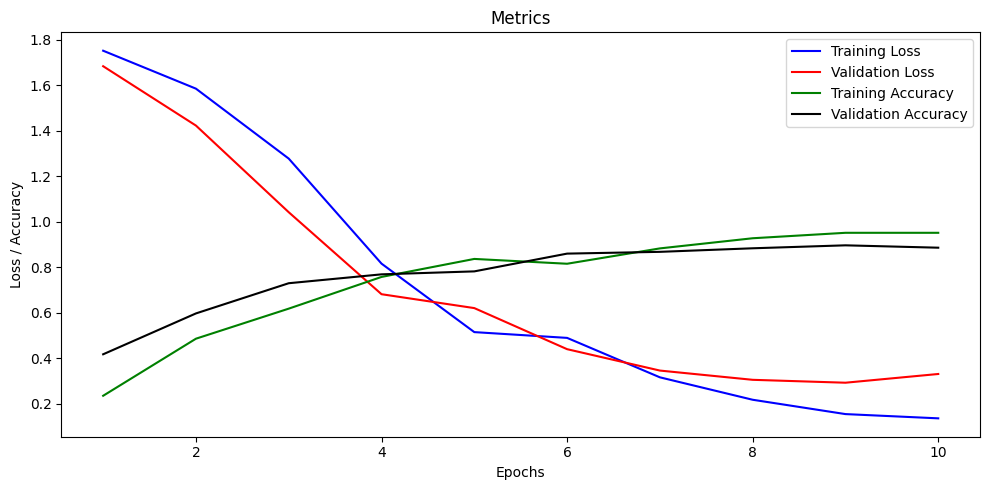

In [ ]:
epochs = range(1, num_epochs + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(epochs, train_loss, label='Training Loss', color = 'blue')
plt.plot(epochs, val_loss, label='Validation Loss', color = 'red')
plt.plot(epochs, accuracy, label='Training Accuracy', color='green')
plt.plot(epochs, accuracy_v, label='Validation Accuracy', color='black')

plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# where to save the weights
model_path = '/content/drive/MyDrive/VISIOPE_Project/weights/10_ep_resnet_only_trash-net.pth'
torch.save(model.state_dict(), model_path)

### CONFUSION MATRIX TRAINING

Accuracy: 0.950920245398773
Precision: 0.9508750875681573
Recall: 0.950920245398773
F1 Score: 0.950799159823627


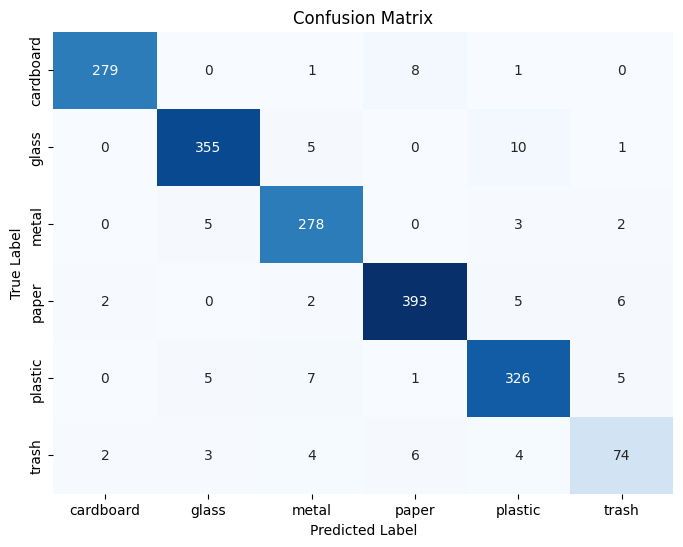

In [ ]:
# TO CHOOSE THE LABELS' LIST (for different dataset examined)

#label = ['biodegradable','glass','paper','plastic', 'special', 'trash']

label = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] #trash-net
# Calculate evaluation metrics
accuracy = accuracy_score(true_label_train, pred_label_train)
precision = precision_score(true_label_train, pred_label_train, average = 'weighted')
recall = recall_score(true_label_train, pred_label_train, average = 'weighted')
f1 = f1_score(true_label_train, pred_label_train, average = 'weighted')
conf_matrix = confusion_matrix(true_label_train, pred_label_train)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# TO PLOT CONFUSION MATRIX
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(label), yticklabels=np.unique(label))

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Testing

In [ ]:
#TEST

# TO DO TESTING FROM A CSV FILE
csv_file_path = data_dir_path+'test_class.csv'
df_test = pd.read_csv(csv_file_path)

true_lab = []
pred_lab = []

model.eval()
with torch.no_grad():
  for i in range(len(df_test)):
    img_path = df_test.iloc[i, 0]
    label = int(df_test.iloc[i, 1])

    # Load image
    image = Image.open(data_dir_path+img_path).convert("RGB")
    image = transform(image)

    x = image.to(device)
    y = label.to(device)
    outputs = model(x)
    # Calculate metrics as needed
    _, predicted = torch.max(outputs.data, 1)

    y = y.cpu()
    predicted = predicted.cpu()

    for elem in labels: true_lab.append(elem)
    for elem in predicted: pred_lab.append(elem)

  accuracy = accuracy_score(true_lab, pred_lab)
  precision = precision_score(true_lab, pred_lab, average = 'weighted')
  recall = recall_score(true_lab, pred_lab, average = 'weighted')
  f1 = f1_score(true_lab, pred_lab, average = 'weighted')
  conf_matrix = confusion_matrix(true_lab, pred_lab)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# TO PLOT CONFUSION MATRIX
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(label), yticklabels=np.unique(label))

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Test Report")
print(classification_report(true_lab, pred_lab, digits = 4))

Accuracy: 0.9038961038961039
Precision: 0.904270532913966
Recall: 0.9038961038961039
F1 Score: 0.9010812896859408


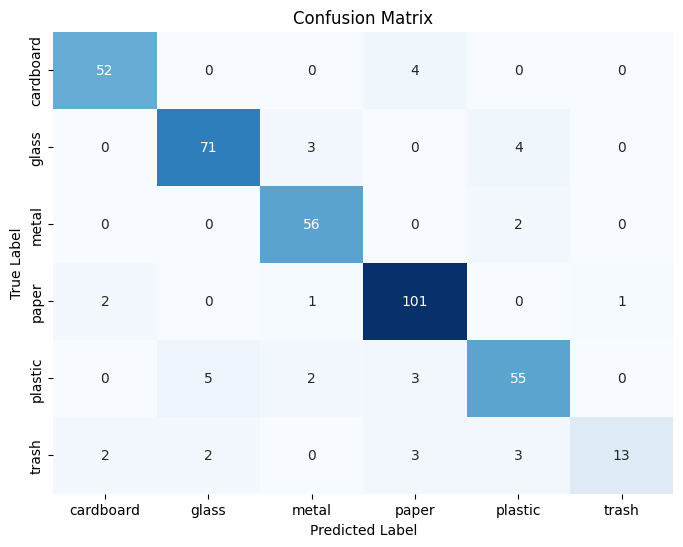

Test Report
              precision    recall  f1-score   support

           0     0.9286    0.9286    0.9286        56
           1     0.9103    0.9103    0.9103        78
           2     0.9032    0.9655    0.9333        58
           3     0.9099    0.9619    0.9352       105
           4     0.8594    0.8462    0.8527        65
           5     0.9286    0.5652    0.7027        23

    accuracy                         0.9039       385
   macro avg     0.9067    0.8629    0.8771       385
weighted avg     0.9043    0.9039    0.9011       385



In [ ]:
#TEST

# TO DO TESTING FROM A TEST LOADER

# Evaluation loop (replace this with your own evaluation logic)

dir_label = {0 : 'biodegradable', 1 : 'glass', 2 : 'paper', 3 : 'plastic', 4 : 'special', 5 : 'trash'}

true_lab = []
pred_lab = []

model.eval()
with torch.no_grad():
  for inputs, labels in test_loader:
    x = inputs.to(device)
    y = labels.to(device)
    outputs = model(x)
    # Calculate metrics as needed
    _, predicted = torch.max(outputs.data, 1)

    y = y.cpu()
    predicted = predicted.cpu()

    # for i in range(128):
    #   if y[i] != predicted[i]: print('TRUE', dir_label[y[i].item()], 'PREDICT', dir_label[predicted[i].item()])

    for elem in labels: true_lab.append(elem)
    for elem in predicted: pred_lab.append(elem)

  accuracy = accuracy_score(true_lab, pred_lab)
  precision = precision_score(true_lab, pred_lab, average = 'weighted')
  recall = recall_score(true_lab, pred_lab, average = 'weighted')
  f1 = f1_score(true_lab, pred_lab, average = 'weighted')
  conf_matrix = confusion_matrix(true_lab, pred_lab)

# TO PLOT CONFUSION MATRIX
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(label), yticklabels=np.unique(label))

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Test Report")
print(classification_report(true_lab, pred_lab, digits = 4))